In [1]:
# 1 - Install libraries


!pip install transformers
!pip install tqdm



ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 4, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/main.py", line 11, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/main_parser.py", line 5, in <module>
    import subprocess
  File "/usr/lib/python3.11/subprocess.py", line 119, in <module>
    import selectors
  File "/usr/lib/python3.11/selectors.py", line 46, in <module>
    SelectorKey = namedtuple('SelectorKey', ['fileobj', 'fd', 'events', 'data'])
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/collections/__init__.py", line 378, in 

In [ ]:
# 2 - Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import ast



2025-05-05 05:23:55.830718: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746422635.853046     277 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746422635.860057     277 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# 3 - Device setup and random seed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)


Using device: cuda


In [ ]:
# A) With U3 in Training:
import pandas as pd

# Load the dataset (with U3 included)
df_with_u3 = pd.read_csv('/kaggle/input/dsddyadic-peld-tsv/Dyadic_PELD.tsv', sep='\t')

# Print the shape and a preview of the dataset
print("Dataset shape (with U3):", df_with_u3.shape)
print(df_with_u3[['Utterance_1', 'Utterance_2', 'Utterance_3', 'Emotion_3']].head())

# Split the dataset for training, validation, and testing
train_df_with_u3, temp_df_with_u3 = train_test_split(df_with_u3, test_size=0.2, stratify=df_with_u3['Emotion_3'], random_state=SEED)
val_df_with_u3, test_df_with_u3 = train_test_split(temp_df_with_u3, test_size=0.5, stratify=temp_df_with_u3['Emotion_3'], random_state=SEED)

# Print the sizes of the splits
print(f"Train size (with U3): {len(train_df_with_u3)}")
print(f"Validation size (with U3): {len(val_df_with_u3)}")
print(f"Test size (with U3): {len(test_df_with_u3)}")

# B) Without U3 in Training:
# Load the dataset (without U3 included)
df_without_u3 = pd.read_csv('/kaggle/input/dsddyadic-peld-tsv/Dyadic_PELD.tsv', sep='\t')

# Drop 'Utterance_3' for training without U3
df_without_u3 = df_without_u3.drop(columns=['Utterance_3'])

# Print the shape and a preview of the dataset
print("Dataset shape (without U3):", df_without_u3.shape)
print(df_without_u3[['Utterance_1', 'Utterance_2', 'Emotion_3']].head())

# Split the dataset for training, validation, and testing
train_df_without_u3, temp_df_without_u3 = train_test_split(df_without_u3, test_size=0.2, stratify=df_without_u3['Emotion_3'], random_state=SEED)
val_df_without_u3, test_df_without_u3 = train_test_split(temp_df_without_u3, test_size=0.5, stratify=temp_df_without_u3['Emotion_3'], random_state=SEED)

# Print the sizes of the splits
print(f"Train size (without U3): {len(train_df_without_u3)}")
print(f"Validation size (without U3): {len(val_df_without_u3)}")
print(f"Test size (without U3): {len(test_df_without_u3)}")


Dataset shape (with U3): (6510, 12)
                                         Utterance_1  \
0  also I was the point person on my company s tr...   
1                            That I did. That I did.   
2                             My duties?  All right.   
3                                             I see.   
4                                      Good to know.   

                                         Utterance_2              Utterance_3  \
0                   You must ve had your hands full.  That I did. That I did.   
1      So let s talk a little bit about your duties.   My duties?  All right.   
2  Now you ll be heading a whole division, so you...                   I see.   
3  But there ll be perhaps 30 people under you so...            Good to know.   
4                              We can go into detail   No don t I beg of you!   

  Emotion_3  
0   neutral  
1  surprise  
2   neutral  
3   neutral  
4      fear  
Train size (with U3): 5208
Validation size (with U3): 65

In [ ]:

# 5. Label encoding and personality vector extraction

#A) With U3 in Training:
from sklearn.preprocessing import LabelEncoder

# Convert Personality column (string) to float array
df_with_u3['Personality_Vector'] = df_with_u3['Personality'].apply(lambda x: np.array(ast.literal_eval(x), dtype=np.float32))

# Label encode the target emotion
label_encoder = LabelEncoder()
df_with_u3['Emotion_Label'] = label_encoder.fit_transform(df_with_u3['Emotion_3'])

# Show label mapping
print("Emotion to label mapping (with U3 in training):")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")

# B) Without U3 in Training:
from sklearn.preprocessing import LabelEncoder

# Convert Personality column (string) to float array
df_without_u3['Personality_Vector'] = df_without_u3['Personality'].apply(lambda x: np.array(ast.literal_eval(x), dtype=np.float32))

# Label encode the target emotion
label_encoder = LabelEncoder()
df_without_u3['Emotion_Label'] = label_encoder.fit_transform(df_without_u3['Emotion_3'])

# Show label mapping
print("Emotion to label mapping (without U3 in training):")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")



Emotion to label mapping (with U3 in training):
anger: 0
disgust: 1
fear: 2
joy: 3
neutral: 4
sadness: 5
surprise: 6
Emotion to label mapping (without U3 in training):
anger: 0
disgust: 1
fear: 2
joy: 3
neutral: 4
sadness: 5
surprise: 6


In [ ]:
#  6- Define emotion-to-VAD mapping (from paper)
emotion_vad = {
    'anger':    [-0.51,  0.59,  0.25],
    'disgust':  [-0.60,  0.35,  0.11],
    'fear':     [-0.62,  0.82, -0.43],
    'joy':      [ 0.81,  0.51,  0.46],
    'neutral':  [ 0.00,  0.00,  0.00],
    'sadness':  [-0.63, -0.27, -0.33],
    'surprise': [ 0.40,  0.67, -0.13]
}

# A) For Dataset with U3 (using Emotion_1, Emotion_2, Emotion_3)
for i in [1, 2, 3]:  # Iterating through Emotion_1, Emotion_2, Emotion_3
    df_with_u3[f'VAD_{i}'] = df_with_u3[f'Emotion_{i}'].apply(lambda e: emotion_vad.get(e, [0.0, 0.0, 0.0]))

# B) For Dataset without U3 (using only Emotion_1, Emotion_2)
for i in [1, 2]:  # Only Emotion_1 and Emotion_2 (no Emotion_3)
    df_without_u3[f'VAD_{i}'] = df_without_u3[f'Emotion_{i}'].apply(lambda e: emotion_vad.get(e, [0.0, 0.0, 0.0]))


In [ ]:
# 7: Split the Data for Training, Validation, and Testing

# Set random seed
SEED = 42

# A) Split data for Dataset with U3 (train_df_with_u3, val_df_with_u3, test_df_with_u3)
train_df_with_u3, temp_df_with_u3 = train_test_split(df_with_u3, test_size=0.2, stratify=df_with_u3['Emotion_Label'], random_state=SEED)
val_df_with_u3, test_df_with_u3 = train_test_split(temp_df_with_u3, test_size=0.5, stratify=temp_df_with_u3['Emotion_Label'], random_state=SEED)

print(f"Train size (with U3): {len(train_df_with_u3)}")
print(f"Validation size (with U3): {len(val_df_with_u3)}")
print(f"Test size (with U3): {len(test_df_with_u3)}")

# B) Split data for Dataset without U3 (train_df_without_u3, val_df_without_u3, test_df_without_u3)
train_df_without_u3, temp_df_without_u3 = train_test_split(df_without_u3, test_size=0.2, stratify=df_without_u3['Emotion_Label'], random_state=SEED)
val_df_without_u3, test_df_without_u3 = train_test_split(temp_df_without_u3, test_size=0.5, stratify=temp_df_without_u3['Emotion_Label'], random_state=SEED)

print(f"Train size (without U3): {len(train_df_without_u3)}")
print(f"Validation size (without U3): {len(val_df_without_u3)}")
print(f"Test size (without U3): {len(test_df_without_u3)}")


Train size (with U3): 5208
Validation size (with U3): 651
Test size (with U3): 651
Train size (without U3): 5208
Validation size (without U3): 651
Test size (without U3): 651


In [ ]:
#  8: Tokenization with U3 (For Both Training and Testing)


# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
MAX_LEN = 128

# Tokenization function (with U1, U2, U3)
def tokenize_triplet(u1, u2, u3=None):
    if u3 is not None:
        combined = u1 + " [SEP] " + u2 + " [SEP] " + u3
    else:
        combined = u1 + " [SEP] " + u2  # Without U3, just tokenizing U1 and U2
    tokens = tokenizer(combined, max_length=MAX_LEN, truncation=True, padding='max_length', return_tensors='pt')
    return tokens['input_ids'].squeeze(0), tokens['attention_mask'].squeeze(0)

# Tokenize entire DataFrame
def tokenize_dataframe(dataframe, with_u3=True):
    input_ids_list = []
    attention_mask_list = []
    if with_u3:
        for u1, u2, u3 in zip(dataframe['Utterance_1'], dataframe['Utterance_2'], dataframe['Utterance_3']):
            ids, mask = tokenize_triplet(u1, u2, u3)
            input_ids_list.append(ids)
            attention_mask_list.append(mask)
    else:
        for u1, u2 in zip(dataframe['Utterance_1'], dataframe['Utterance_2']):
            ids, mask = tokenize_triplet(u1, u2, None)  # no U3
            input_ids_list.append(ids)
            attention_mask_list.append(mask)
    return torch.stack(input_ids_list), torch.stack(attention_mask_list)


# A) Tokenization for Dataset with U3 (training, validation, and test)
def tokenize_dataframe_with_u3(dataframe):
    input_ids_list = []
    attention_mask_list = []
    for u1, u2, u3 in zip(dataframe['Utterance_1'], dataframe['Utterance_2'], dataframe['Utterance_3']):
        ids, mask = tokenize_triplet(u1, u2, u3)
        input_ids_list.append(ids)
        attention_mask_list.append(mask)
    return torch.stack(input_ids_list), torch.stack(attention_mask_list)

# Apply tokenization for training, validation, and test data with U3
train_input_ids_with_u3, train_attention_masks_with_u3 = tokenize_dataframe_with_u3(train_df_with_u3)
val_input_ids_with_u3, val_attention_masks_with_u3 = tokenize_dataframe_with_u3(val_df_with_u3)
test_input_ids_with_u3, test_attention_masks_with_u3 = tokenize_dataframe_with_u3(test_df_with_u3)

# B) Tokenization for Dataset without U3 (training, validation, and test)
def tokenize_dataframe_without_u3(dataframe):
    input_ids_list = []
    attention_mask_list = []
    for u1, u2 in zip(dataframe['Utterance_1'], dataframe['Utterance_2']):
        combined = u1 + " [SEP] " + u2
        tokens = tokenizer(combined, max_length=MAX_LEN, truncation=True, padding='max_length', return_tensors='pt')
        input_ids_list.append(tokens['input_ids'].squeeze(0))
        attention_mask_list.append(tokens['attention_mask'].squeeze(0))
    return torch.stack(input_ids_list), torch.stack(attention_mask_list)

# Apply tokenization for training, validation, and test data without U3
train_input_ids_without_u3, train_attention_masks_without_u3 = tokenize_dataframe_without_u3(train_df_without_u3)
val_input_ids_without_u3, val_attention_masks_without_u3 = tokenize_dataframe_without_u3(val_df_without_u3)
test_input_ids_without_u3, test_attention_masks_without_u3 = tokenize_dataframe_without_u3(test_df_without_u3)


In [ ]:
#  9: Extract Personality and VAD Features


# Function to add VAD and extract tensors
def extract_features_with_u3(df):
    personality = torch.tensor(np.stack(df['Personality_Vector'].values), dtype=torch.float32)
    # VAD calculation considering Emotion_1, Emotion_2, and Emotion_3
    vad = torch.tensor([emotion_vad.get(em, [0.0, 0.0, 0.0]) for em in df['Emotion_1']], dtype=torch.float32)
    labels = torch.tensor(df['Emotion_Label'].values, dtype=torch.long)
    return personality, vad, labels

# A) Apply to all splits for with U3 dataset
train_personality_with_u3, train_vad_with_u3, train_labels_with_u3 = extract_features_with_u3(train_df_with_u3)
val_personality_with_u3, val_vad_with_u3, val_labels_with_u3 = extract_features_with_u3(val_df_with_u3)
test_personality_with_u3, test_vad_with_u3, test_labels_with_u3 = extract_features_with_u3(test_df_with_u3)

# B) Apply to all splits for without U3 dataset
def extract_features_without_u3(df):
    personality = torch.tensor(np.stack(df['Personality_Vector'].values), dtype=torch.float32)
    # VAD calculation considering Emotion_1 and Emotion_2 only (without Emotion_3)
    vad = torch.tensor([emotion_vad.get(em, [0.0, 0.0, 0.0]) for em in df['Emotion_1']], dtype=torch.float32)
    labels = torch.tensor(df['Emotion_Label'].values, dtype=torch.long)
    return personality, vad, labels

train_personality_without_u3, train_vad_without_u3, train_labels_without_u3 = extract_features_without_u3(train_df_without_u3)
val_personality_without_u3, val_vad_without_u3, val_labels_without_u3 = extract_features_without_u3(val_df_without_u3)
test_personality_without_u3, test_vad_without_u3, test_labels_without_u3 = extract_features_without_u3(test_df_without_u3)


In [ ]:
# 10: Create Dataset Object for DataLoader

from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

# Define the dataset class
class EmotionDataset(Dataset):
    def __init__(self, input_ids, attention_mask, personality, vad, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.personality = personality
        self.vad = vad
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'personality': self.personality[idx],
            'vad': self.vad[idx],
            'label': self.labels[idx]
        }

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
MAX_LEN = 128

# Tokenization function (with U1, U2, U3)
def tokenize_triplet(u1, u2, u3=None):
    if u3 is not None:
        combined = u1 + " [SEP] " + u2 + " [SEP] " + u3
    else:
        combined = u1 + " [SEP] " + u2
    tokens = tokenizer(combined, max_length=MAX_LEN, truncation=True, padding='max_length', return_tensors='pt')
    return tokens['input_ids'].squeeze(0), tokens['attention_mask'].squeeze(0)

# Tokenize entire DataFrame
def tokenize_dataframe(dataframe, with_u3=True):
    input_ids_list = []
    attention_mask_list = []
    if with_u3:
        for u1, u2, u3 in zip(dataframe['Utterance_1'], dataframe['Utterance_2'], dataframe['Utterance_3']):
            ids, mask = tokenize_triplet(u1, u2, u3)
            input_ids_list.append(ids)
            attention_mask_list.append(mask)
    else:
        for u1, u2 in zip(dataframe['Utterance_1'], dataframe['Utterance_2']):
            ids, mask = tokenize_triplet(u1, u2, None)  # no U3
            input_ids_list.append(ids)
            attention_mask_list.append(mask)
    return torch.stack(input_ids_list), torch.stack(attention_mask_list)

# A) Tokenize and extract features for With U3 dataset
print("Tokenizing and extracting features for With U3 dataset...")

# Apply tokenization for train, val, test data (with U3)
train_input_ids_with_u3, train_attention_masks_with_u3 = tokenize_dataframe(train_df_with_u3, with_u3=True)
val_input_ids_with_u3, val_attention_masks_with_u3 = tokenize_dataframe(val_df_with_u3, with_u3=True)
test_input_ids_with_u3, test_attention_masks_with_u3 = tokenize_dataframe(test_df_with_u3, with_u3=True)

# Extract personality and VAD features for the With U3 dataset
train_personality_with_u3, train_vad_with_u3, train_labels_with_u3 = extract_features_with_u3(train_df_with_u3)
val_personality_with_u3, val_vad_with_u3, val_labels_with_u3 = extract_features_with_u3(val_df_with_u3)
test_personality_with_u3, test_vad_with_u3, test_labels_with_u3 = extract_features_with_u3(test_df_with_u3)

# Print data shapes for With U3 dataset
print("With U3 dataset shapes:")
print(f"Train: {train_input_ids_with_u3.shape}, {train_personality_with_u3.shape}, {train_vad_with_u3.shape}")
print(f"Validation: {val_input_ids_with_u3.shape}, {val_personality_with_u3.shape}, {val_vad_with_u3.shape}")
print(f"Test: {test_input_ids_with_u3.shape}, {test_personality_with_u3.shape}, {test_vad_with_u3.shape}")

# Create dataset objects for the With U3 dataset
train_dataset_with_u3 = EmotionDataset(train_input_ids_with_u3, train_attention_masks_with_u3, train_personality_with_u3, train_vad_with_u3, train_labels_with_u3)
val_dataset_with_u3 = EmotionDataset(val_input_ids_with_u3, val_attention_masks_with_u3, val_personality_with_u3, val_vad_with_u3, val_labels_with_u3)
test_dataset_with_u3 = EmotionDataset(test_input_ids_with_u3, test_attention_masks_with_u3, test_personality_with_u3, test_vad_with_u3, test_labels_with_u3)

print("Dataset objects created for With U3")

# B) Tokenize and extract features for Without U3 dataset
print("Tokenizing and extracting features for Without U3 dataset...")

# Apply tokenization for train, val, test data (without U3)
train_input_ids_without_u3, train_attention_masks_without_u3 = tokenize_dataframe(train_df_without_u3, with_u3=False)
val_input_ids_without_u3, val_attention_masks_without_u3 = tokenize_dataframe(val_df_without_u3, with_u3=False)
test_input_ids_without_u3, test_attention_masks_without_u3 = tokenize_dataframe(test_df_without_u3, with_u3=False)

# Extract personality and VAD features for the Without U3 dataset
train_personality_without_u3, train_vad_without_u3, train_labels_without_u3 = extract_features_without_u3(train_df_without_u3)
val_personality_without_u3, val_vad_without_u3, val_labels_without_u3 = extract_features_without_u3(val_df_without_u3)
test_personality_without_u3, test_vad_without_u3, test_labels_without_u3 = extract_features_without_u3(test_df_without_u3)

# Print data shapes for Without U3 dataset
print("Without U3 dataset shapes:")
print(f"Train: {train_input_ids_without_u3.shape}, {train_personality_without_u3.shape}, {train_vad_without_u3.shape}")
print(f"Validation: {val_input_ids_without_u3.shape}, {val_personality_without_u3.shape}, {val_vad_without_u3.shape}")
print(f"Test: {test_input_ids_without_u3.shape}, {test_personality_without_u3.shape}, {test_vad_without_u3.shape}")

# Create dataset objects for the Without U3 dataset
train_dataset_without_u3 = EmotionDataset(train_input_ids_without_u3, train_attention_masks_without_u3, train_personality_without_u3, train_vad_without_u3, train_labels_without_u3)
val_dataset_without_u3 = EmotionDataset(val_input_ids_without_u3, val_attention_masks_without_u3, val_personality_without_u3, val_vad_without_u3, val_labels_without_u3)
test_dataset_without_u3 = EmotionDataset(test_input_ids_without_u3, test_attention_masks_without_u3, test_personality_without_u3, test_vad_without_u3, test_labels_without_u3)

print("Dataset objects created for Without U3")


Tokenizing and extracting features for With U3 dataset...
With U3 dataset shapes:
Train: torch.Size([5208, 128]), torch.Size([5208, 5]), torch.Size([5208, 3])
Validation: torch.Size([651, 128]), torch.Size([651, 5]), torch.Size([651, 3])
Test: torch.Size([651, 128]), torch.Size([651, 5]), torch.Size([651, 3])
Dataset objects created for With U3
Tokenizing and extracting features for Without U3 dataset...
Without U3 dataset shapes:
Train: torch.Size([5208, 128]), torch.Size([5208, 5]), torch.Size([5208, 3])
Validation: torch.Size([651, 128]), torch.Size([651, 5]), torch.Size([651, 3])
Test: torch.Size([651, 128]), torch.Size([651, 5]), torch.Size([651, 3])
Dataset objects created for Without U3


In [ ]:
# 11: Define the Model (BERT + BiGRU + Attention)


class EmotionClassifier(nn.Module):
    def __init__(self, hidden_size=768, fusion_dim=128, num_classes=7):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")

        # BiGRU after BERT
        self.gru = nn.GRU(input_size=hidden_size, hidden_size=fusion_dim,
                          batch_first=True, bidirectional=True)

        # MLP Attention
        self.attn = nn.Sequential(
            nn.Linear(fusion_dim * 2, fusion_dim),
            nn.Tanh(),
            nn.Linear(fusion_dim, 1)
        )

        # Fusion layer: [GRU context + VAD + Personality]
        self.fusion = nn.Sequential(
            nn.Linear(fusion_dim * 2 + 3 + 5, fusion_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Heads
        self.classifier = nn.Linear(fusion_dim, num_classes)
        self.vad_head = nn.Linear(fusion_dim, 3)

        # Unfreeze top N BERT layers
        self.unfreeze_layers(6)

    def attention_net(self, gru_output):
        scores = self.attn(gru_output).squeeze(-1)            # (B, seq_len)
        weights = torch.softmax(scores, dim=1).unsqueeze(-1)  # (B, seq_len, 1)
        context = torch.sum(gru_output * weights, dim=1)      # (B, 2*hidden)
        return context

    def forward(self, input_ids, attention_mask, personality, vad):
        bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = bert_out.last_hidden_state                         # (B, seq_len, 768)
        gru_out, _ = self.gru(x)                               # (B, seq_len, 2*hidden)
        context = self.attention_net(gru_out)                  # (B, 2*hidden)

        fused_input = torch.cat([context, personality, vad], dim=1)  # (B, ...)
        fused = self.fusion(fused_input)

        emotion_logits = self.classifier(fused)
        vad_pred = self.vad_head(fused)

        return emotion_logits, vad_pred

    def unfreeze_layers(self, num_layers):
        for name, param in self.bert.named_parameters():
            if "encoder.layer" in name:
                layer_num = int(name.split("layer.")[1].split(".")[0])
                if layer_num >= (12 - num_layers):
                    param.requires_grad = True
        for param in self.bert.pooler.parameters():
            param.requires_grad = True



In [ ]:
# 12 Calculate Class Weights

# With U3 (Training with Utterance_3)


from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler




# Compute class weights for imbalanced emotion labels (with U3)
class_weights_with_u3 = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df_with_u3['Emotion_Label']),
    y=train_df_with_u3['Emotion_Label']
)
class_weights_tensor_with_u3 = torch.tensor(class_weights_with_u3, dtype=torch.float).to(device)

# Instantiate model (with U3)
model_with_u3 = EmotionClassifier().to(device)

# Define loss
criterion_with_u3 = nn.CrossEntropyLoss(weight=class_weights_tensor_with_u3)

# Optimizer
optimizer_with_u3 = torch.optim.AdamW(model_with_u3.parameters(), lr=2e-5, weight_decay=1e-4)

# Set batch size
BATCH_SIZE = 16

# Weighted sampling for with U3
sample_weights_with_u3 = class_weights_tensor_with_u3[train_labels_with_u3].cpu().numpy()
sampler_with_u3 = WeightedRandomSampler(weights=sample_weights_with_u3, num_samples=len(sample_weights_with_u3), replacement=True)

# DataLoaders for with U3
train_loader_with_u3 = DataLoader(train_dataset_with_u3, batch_size=BATCH_SIZE, sampler=sampler_with_u3)
val_loader_with_u3   = DataLoader(val_dataset_with_u3, batch_size=BATCH_SIZE)
test_loader_with_u3  = DataLoader(test_dataset_with_u3, batch_size=BATCH_SIZE)

print("✅ DataLoaders created with WeightedRandomSampler (with U3)!")


✅ DataLoaders created with WeightedRandomSampler (with U3)!


In [ ]:
# 13   Calculate Class Weights

#  Without U3 (Training without Utterance_3)

# Compute class weights for imbalanced emotion labels (without U3)
class_weights_without_u3 = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df_without_u3['Emotion_Label']),
    y=train_df_without_u3['Emotion_Label']
)
class_weights_tensor_without_u3 = torch.tensor(class_weights_without_u3, dtype=torch.float).to(device)

# Instantiate model (without U3)
model_without_u3 = EmotionClassifier().to(device)

# Define loss
criterion_without_u3 = nn.CrossEntropyLoss(weight=class_weights_tensor_without_u3)

# Optimizer
optimizer_without_u3 = torch.optim.AdamW(model_without_u3.parameters(), lr=2e-5, weight_decay=1e-4)

# Set batch size
BATCH_SIZE = 16

# Weighted sampling for without U3
sample_weights_without_u3 = class_weights_tensor_without_u3[train_labels_without_u3].cpu().numpy()
sampler_without_u3 = WeightedRandomSampler(weights=sample_weights_without_u3, num_samples=len(sample_weights_without_u3), replacement=True)

# DataLoaders for without U3
train_loader_without_u3 = DataLoader(train_dataset_without_u3, batch_size=BATCH_SIZE, sampler=sampler_without_u3)
val_loader_without_u3   = DataLoader(val_dataset_without_u3, batch_size=BATCH_SIZE)
test_loader_without_u3  = DataLoader(test_dataset_without_u3, batch_size=BATCH_SIZE)

print("✅ DataLoaders created with WeightedRandomSampler (without U3)!")


✅ DataLoaders created with WeightedRandomSampler (without U3)!


In [ ]:
#14  Training the Model (With U3)

from tqdm import tqdm
from sklearn.metrics import f1_score

# Training the Model (With U3)
def train_model_with_u3(model, train_loader_with_u3, val_loader_with_u3, optimizer, criterion, scheduler=None, epochs=100, patience=5):
    best_f1 = 0.0
    patience_counter = 0
    loss_history_with_u3 = []
    f1_history_with_u3 = []

    max_unfreeze = 12
    unfreeze_every = 5

    for epoch in range(epochs):
        model.train()

        if epoch > 0 and epoch % unfreeze_every == 0 and (epoch // unfreeze_every) <= max_unfreeze:
            layers_to_unfreeze = epoch // unfreeze_every + 2
            model.unfreeze_layers(layers_to_unfreeze)
            print(f"🔓 Unfroze last {layers_to_unfreeze} BERT layers at epoch {epoch+1}")

        total_loss = 0.0
        progress_bar = tqdm(train_loader_with_u3, desc=f"Epoch {epoch+1}/{epochs}")

        for batch_idx, batch in enumerate(progress_bar):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            personality = batch['personality'].to(device)
            vad = batch['vad'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()

            # Unpack model output
            emotion_logits, vad_pred = model(input_ids, attention_mask, personality, vad)

            # Multi-task loss: classification + VAD regression
            loss_emotion = criterion(emotion_logits, labels)
            loss_vad = F.mse_loss(vad_pred, vad)
            loss = loss_emotion + 0.3 * loss_vad

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            avg_batch_loss = total_loss / (batch_idx + 1)
            progress_bar.set_postfix(Train_Loss=f"{avg_batch_loss:.4f}")

        avg_loss = total_loss / len(train_loader_with_u3)
        loss_history_with_u3.append(avg_loss)

        model.eval()
        val_preds, val_true = [], []
        with torch.no_grad():
            for batch in val_loader_with_u3:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                personality = batch['personality'].to(device)
                vad = batch['vad'].to(device)
                labels = batch['label'].to(device)

                emotion_logits, _ = model(input_ids, attention_mask, personality, vad)
                preds = torch.argmax(emotion_logits, dim=1)

                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        val_f1 = f1_score(val_true, val_preds, average='macro')
        f1_history_with_u3.append(val_f1)

        print(f"\nEpoch {epoch+1}/{epochs} Summary → Train Loss: {avg_loss:.4f} | Val F1 Macro: {val_f1:.4f}")

        if scheduler:
            scheduler.step(val_f1)

        if val_f1 > best_f1:
            best_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), "best_emotion_model_with_u3.pt")
            print("✅ New best model saved!")
        else:
            patience_counter += 1
            print(f"🕒 No improvement. Patience: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("⏹️ Early stopping triggered!")
                break

    print("🏁 Training complete!")
    return loss_history_with_u3, f1_history_with_u3


In [ ]:
# 15  Training the Model
# Training the Model (Without U3)
def train_model_without_u3(model, train_loader_without_u3, val_loader_without_u3, optimizer, criterion, scheduler=None, epochs=100, patience=5):
    best_f1 = 0.0
    patience_counter = 0
    loss_history_without_u3 = []
    f1_history_without_u3 = []

    max_unfreeze = 12
    unfreeze_every = 5

    for epoch in range(epochs):
        model.train()

        if epoch > 0 and epoch % unfreeze_every == 0 and (epoch // unfreeze_every) <= max_unfreeze:
            layers_to_unfreeze = epoch // unfreeze_every + 2
            model.unfreeze_layers(layers_to_unfreeze)
            print(f"🔓 Unfroze last {layers_to_unfreeze} BERT layers at epoch {epoch+1}")

        total_loss = 0.0
        progress_bar = tqdm(train_loader_without_u3, desc=f"Epoch {epoch+1}/{epochs}")

        for batch_idx, batch in enumerate(progress_bar):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            personality = batch['personality'].to(device)
            vad = batch['vad'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()

            # Unpack model output
            emotion_logits, vad_pred = model(input_ids, attention_mask, personality, vad)

            # Multi-task loss: classification + VAD regression
            loss_emotion = criterion(emotion_logits, labels)
            loss_vad = F.mse_loss(vad_pred, vad)
            loss = loss_emotion + 0.3 * loss_vad

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            avg_batch_loss = total_loss / (batch_idx + 1)
            progress_bar.set_postfix(Train_Loss=f"{avg_batch_loss:.4f}")

        avg_loss = total_loss / len(train_loader_without_u3)
        loss_history_without_u3.append(avg_loss)

        model.eval()
        val_preds, val_true = [], []
        with torch.no_grad():
            for batch in val_loader_without_u3:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                personality = batch['personality'].to(device)
                vad = batch['vad'].to(device)
                labels = batch['label'].to(device)

                emotion_logits, _ = model(input_ids, attention_mask, personality, vad)
                preds = torch.argmax(emotion_logits, dim=1)

                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        val_f1 = f1_score(val_true, val_preds, average='macro')
        f1_history_without_u3.append(val_f1)

        print(f"\nEpoch {epoch+1}/{epochs} Summary → Train Loss: {avg_loss:.4f} | Val F1 Macro: {val_f1:.4f}")

        if scheduler:
            scheduler.step(val_f1)

        if val_f1 > best_f1:
            best_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), "best_emotion_model_without_u3.pt")
            print("✅ New best model saved!")
        else:
            patience_counter += 1
            print(f"🕒 No improvement. Patience: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("⏹️ Early stopping triggered!")
                break

    print("🏁 Training complete!")
    return loss_history_without_u3, f1_history_without_u3



In [ ]:
# 16 For the model with U3:  Call the train_model_with_u3 function:

scheduler_with_u3 = torch.optim.lr_scheduler.StepLR(optimizer_with_u3, step_size=10, gamma=0.1)

# Example of calling the training function with a scheduler (with U3)
loss_history_with_u3, f1_history_with_u3 = train_model_with_u3(
    model_with_u3, train_loader_with_u3, val_loader_with_u3, optimizer_with_u3, criterion_with_u3, scheduler=scheduler_with_u3, epochs=100
)


Epoch 1/100: 100%|██████████| 326/326 [01:07<00:00,  4.86it/s, Train_Loss=1.4374]



Epoch 1/100 Summary → Train Loss: 1.4374 | Val F1 Macro: 0.1796
✅ New best model saved!


Epoch 2/100: 100%|██████████| 326/326 [01:06<00:00,  4.89it/s, Train_Loss=0.9188]



Epoch 2/100 Summary → Train Loss: 0.9188 | Val F1 Macro: 0.2212
✅ New best model saved!


Epoch 3/100: 100%|██████████| 326/326 [01:06<00:00,  4.89it/s, Train_Loss=0.6755]



Epoch 3/100 Summary → Train Loss: 0.6755 | Val F1 Macro: 0.2471
✅ New best model saved!


Epoch 4/100: 100%|██████████| 326/326 [01:06<00:00,  4.89it/s, Train_Loss=0.4931]



Epoch 4/100 Summary → Train Loss: 0.4931 | Val F1 Macro: 0.2559
✅ New best model saved!


Epoch 5/100: 100%|██████████| 326/326 [01:06<00:00,  4.89it/s, Train_Loss=0.4347]



Epoch 5/100 Summary → Train Loss: 0.4347 | Val F1 Macro: 0.2684
✅ New best model saved!
🔓 Unfroze last 3 BERT layers at epoch 6


Epoch 6/100: 100%|██████████| 326/326 [01:06<00:00,  4.89it/s, Train_Loss=0.3549]



Epoch 6/100 Summary → Train Loss: 0.3549 | Val F1 Macro: 0.2940
✅ New best model saved!


Epoch 7/100: 100%|██████████| 326/326 [01:06<00:00,  4.88it/s, Train_Loss=0.3035]



Epoch 7/100 Summary → Train Loss: 0.3035 | Val F1 Macro: 0.3125
✅ New best model saved!


Epoch 8/100: 100%|██████████| 326/326 [01:06<00:00,  4.89it/s, Train_Loss=0.2601]



Epoch 8/100 Summary → Train Loss: 0.2601 | Val F1 Macro: 0.3257
✅ New best model saved!


Epoch 9/100: 100%|██████████| 326/326 [01:06<00:00,  4.90it/s, Train_Loss=0.2459]



Epoch 9/100 Summary → Train Loss: 0.2459 | Val F1 Macro: 0.3253
🕒 No improvement. Patience: 1/5


Epoch 10/100: 100%|██████████| 326/326 [01:06<00:00,  4.90it/s, Train_Loss=0.2223]



Epoch 10/100 Summary → Train Loss: 0.2223 | Val F1 Macro: 0.3584
✅ New best model saved!
🔓 Unfroze last 4 BERT layers at epoch 11


Epoch 11/100: 100%|██████████| 326/326 [01:06<00:00,  4.90it/s, Train_Loss=0.1973]



Epoch 11/100 Summary → Train Loss: 0.1973 | Val F1 Macro: 0.3482
🕒 No improvement. Patience: 1/5


Epoch 12/100: 100%|██████████| 326/326 [01:06<00:00,  4.90it/s, Train_Loss=0.1903]



Epoch 12/100 Summary → Train Loss: 0.1903 | Val F1 Macro: 0.3340
🕒 No improvement. Patience: 2/5


Epoch 13/100: 100%|██████████| 326/326 [01:06<00:00,  4.89it/s, Train_Loss=0.2032]



Epoch 13/100 Summary → Train Loss: 0.2032 | Val F1 Macro: 0.3386
🕒 No improvement. Patience: 3/5


Epoch 14/100: 100%|██████████| 326/326 [01:06<00:00,  4.89it/s, Train_Loss=0.1645]



Epoch 14/100 Summary → Train Loss: 0.1645 | Val F1 Macro: 0.3441
🕒 No improvement. Patience: 4/5


Epoch 15/100: 100%|██████████| 326/326 [01:06<00:00,  4.89it/s, Train_Loss=0.1548]



Epoch 15/100 Summary → Train Loss: 0.1548 | Val F1 Macro: 0.3463
🕒 No improvement. Patience: 5/5
⏹️ Early stopping triggered!
🏁 Training complete!


In [ ]:
#17 For the model without U3: Call the train_model_without_u3 function

scheduler_without_u3 = torch.optim.lr_scheduler.StepLR(optimizer_without_u3, step_size=10, gamma=0.1)

# Example of calling the training function with a scheduler (without U3)
loss_history_without_u3, f1_history_without_u3 = train_model_without_u3(
    model_without_u3, train_loader_without_u3, val_loader_without_u3, optimizer_without_u3, criterion_without_u3, scheduler=scheduler_without_u3, epochs=100
)


Epoch 1/100: 100%|██████████| 326/326 [01:06<00:00,  4.89it/s, Train_Loss=1.4914]



Epoch 1/100 Summary → Train Loss: 1.4914 | Val F1 Macro: 0.0840
✅ New best model saved!


Epoch 2/100: 100%|██████████| 326/326 [01:06<00:00,  4.89it/s, Train_Loss=1.0726]



Epoch 2/100 Summary → Train Loss: 1.0726 | Val F1 Macro: 0.1222
✅ New best model saved!


Epoch 3/100: 100%|██████████| 326/326 [01:06<00:00,  4.89it/s, Train_Loss=0.8990]



Epoch 3/100 Summary → Train Loss: 0.8990 | Val F1 Macro: 0.1373
✅ New best model saved!


Epoch 4/100: 100%|██████████| 326/326 [01:06<00:00,  4.89it/s, Train_Loss=0.6941]



Epoch 4/100 Summary → Train Loss: 0.6941 | Val F1 Macro: 0.1568
✅ New best model saved!


Epoch 5/100: 100%|██████████| 326/326 [01:06<00:00,  4.89it/s, Train_Loss=0.5611]



Epoch 5/100 Summary → Train Loss: 0.5611 | Val F1 Macro: 0.1630
✅ New best model saved!
🔓 Unfroze last 3 BERT layers at epoch 6


Epoch 6/100: 100%|██████████| 326/326 [01:06<00:00,  4.89it/s, Train_Loss=0.4708]



Epoch 6/100 Summary → Train Loss: 0.4708 | Val F1 Macro: 0.1828
✅ New best model saved!


Epoch 7/100: 100%|██████████| 326/326 [01:06<00:00,  4.89it/s, Train_Loss=0.4007]



Epoch 7/100 Summary → Train Loss: 0.4007 | Val F1 Macro: 0.1358
🕒 No improvement. Patience: 1/5


Epoch 8/100: 100%|██████████| 326/326 [01:06<00:00,  4.89it/s, Train_Loss=0.3636]



Epoch 8/100 Summary → Train Loss: 0.3636 | Val F1 Macro: 0.1566
🕒 No improvement. Patience: 2/5


Epoch 9/100: 100%|██████████| 326/326 [01:06<00:00,  4.89it/s, Train_Loss=0.2972]



Epoch 9/100 Summary → Train Loss: 0.2972 | Val F1 Macro: 0.1620
🕒 No improvement. Patience: 3/5


Epoch 10/100: 100%|██████████| 326/326 [01:06<00:00,  4.89it/s, Train_Loss=0.2683]



Epoch 10/100 Summary → Train Loss: 0.2683 | Val F1 Macro: 0.1809
🕒 No improvement. Patience: 4/5
🔓 Unfroze last 4 BERT layers at epoch 11


Epoch 11/100: 100%|██████████| 326/326 [01:06<00:00,  4.89it/s, Train_Loss=0.2465]



Epoch 11/100 Summary → Train Loss: 0.2465 | Val F1 Macro: 0.1801
🕒 No improvement. Patience: 5/5
⏹️ Early stopping triggered!
🏁 Training complete!


In [ ]:
# 18 Run inference on test set (with U3)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

test_preds_with_u3, test_true_with_u3 = [], []
with torch.no_grad():
    for batch in test_loader_with_u3:  # Use test_loader_with_u3 instead of test_loader
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        personality = batch['personality'].to(device)
        vad = batch['vad'].to(device)
        labels = batch['label'].to(device)

        # Use the correct model (model_with_u3)
        emotion_logits, _ = model_with_u3(input_ids, attention_mask, personality, vad)
        preds = torch.argmax(emotion_logits, dim=1)

        test_preds_with_u3.extend(preds.cpu().numpy())
        test_true_with_u3.extend(labels.cpu().numpy())

# Metrics (with U3)
f1_with_u3 = f1_score(test_true_with_u3, test_preds_with_u3, average='macro')
acc_with_u3 = accuracy_score(test_true_with_u3, test_preds_with_u3)
prec_with_u3 = precision_score(test_true_with_u3, test_preds_with_u3, average='macro', zero_division=0)
rec_with_u3 = recall_score(test_true_with_u3, test_preds_with_u3, average='macro', zero_division=0)

print(f"✅ Test Accuracy (with U3):  {acc_with_u3:.4f}")
print(f"✅ Test Precision (with U3): {prec_with_u3:.4f}")
print(f"✅ Test Recall (with U3):    {rec_with_u3:.4f}")
print(f"✅ Test F1 Macro (with U3):  {f1_with_u3:.4f}")
print("\nClassification Report (with U3):")
print(classification_report(test_true_with_u3, test_preds_with_u3, target_names=label_encoder.classes_, zero_division=0))


✅ Test Accuracy (with U3):  0.4347
✅ Test Precision (with U3): 0.3432
✅ Test Recall (with U3):    0.3579
✅ Test F1 Macro (with U3):  0.3477

Classification Report (with U3):
              precision    recall  f1-score   support

       anger       0.40      0.44      0.42        86
     disgust       0.17      0.13      0.15        15
        fear       0.17      0.23      0.19        48
         joy       0.46      0.51      0.48       112
     neutral       0.61      0.48      0.54       277
     sadness       0.24      0.28      0.26        50
    surprise       0.37      0.43      0.40        63

    accuracy                           0.43       651
   macro avg       0.34      0.36      0.35       651
weighted avg       0.46      0.43      0.44       651



In [ ]:
# 19  Run inference on test set (without U3)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


test_preds_without_u3, test_true_without_u3 = [], []
with torch.no_grad():
    for batch in test_loader_without_u3:  # Use test_loader_without_u3 instead of test_loader
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        personality = batch['personality'].to(device)
        vad = batch['vad'].to(device)
        labels = batch['label'].to(device)

        # Use the correct model (model_without_u3)
        emotion_logits, _ = model_without_u3(input_ids, attention_mask, personality, vad)
        preds = torch.argmax(emotion_logits, dim=1)

        test_preds_without_u3.extend(preds.cpu().numpy())
        test_true_without_u3.extend(labels.cpu().numpy())

# Metrics (without U3)
f1_without_u3 = f1_score(test_true_without_u3, test_preds_without_u3, average='macro')
acc_without_u3 = accuracy_score(test_true_without_u3, test_preds_without_u3)
prec_without_u3 = precision_score(test_true_without_u3, test_preds_without_u3, average='macro', zero_division=0)
rec_without_u3 = recall_score(test_true_without_u3, test_preds_without_u3, average='macro', zero_division=0)

print(f"✅ Test Accuracy (without U3):  {acc_without_u3:.4f}")
print(f"✅ Test Precision (without U3): {prec_without_u3:.4f}")
print(f"✅ Test Recall (without U3):    {rec_without_u3:.4f}")
print(f"✅ Test F1 Macro (without U3):  {f1_without_u3:.4f}")
print("\nClassification Report (without U3):")
print(classification_report(test_true_without_u3, test_preds_without_u3, target_names=label_encoder.classes_, zero_division=0))


✅ Test Accuracy (without U3):  0.2243
✅ Test Precision (without U3): 0.1987
✅ Test Recall (without U3):    0.2144
✅ Test F1 Macro (without U3):  0.1739

Classification Report (without U3):
              precision    recall  f1-score   support

       anger       0.27      0.33      0.29        86
     disgust       0.00      0.00      0.00        15
        fear       0.11      0.25      0.15        48
         joy       0.22      0.58      0.32       112
     neutral       0.45      0.10      0.17       277
     sadness       0.24      0.18      0.21        50
    surprise       0.10      0.06      0.08        63

    accuracy                           0.22       651
   macro avg       0.20      0.21      0.17       651
weighted avg       0.30      0.22      0.20       651



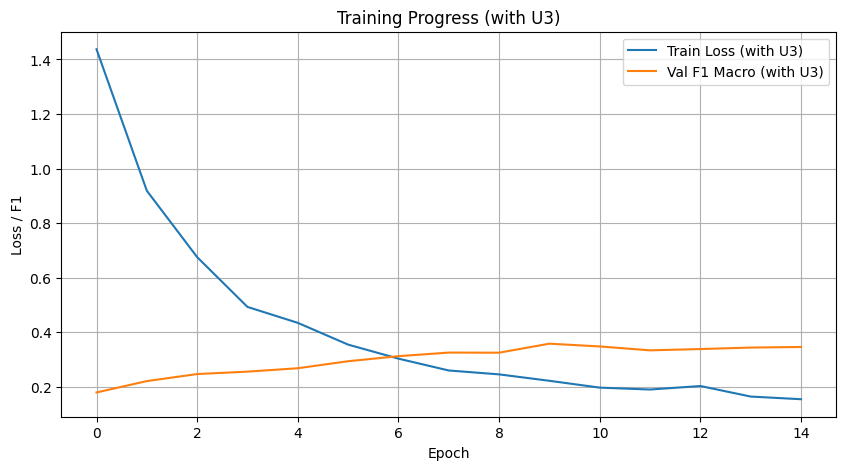

In [ ]:
# 20  Plotting the training progress for the model with U3
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_history_with_u3, label='Train Loss (with U3)')
plt.plot(f1_history_with_u3, label='Val F1 Macro (with U3)')
plt.xlabel("Epoch")
plt.ylabel("Loss / F1")
plt.title("Training Progress (with U3)")
plt.legend()
plt.grid(True)
plt.show()


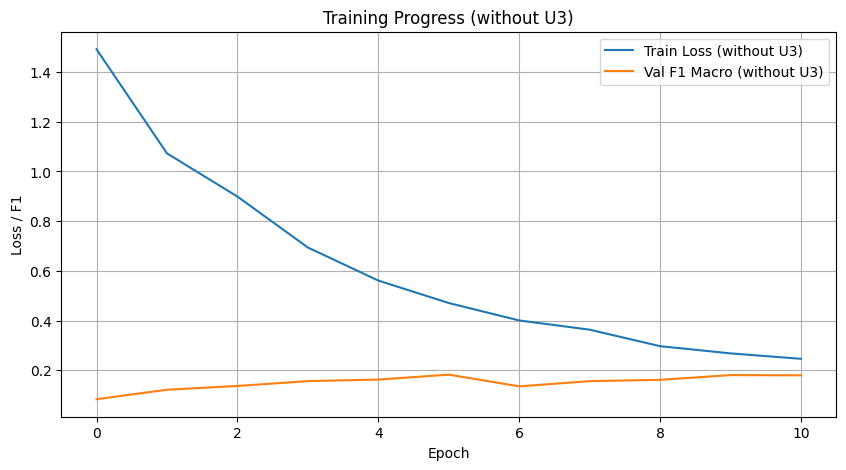

In [ ]:
#  21 Plotting the training progress for the model without U3
plt.figure(figsize=(10, 5))
plt.plot(loss_history_without_u3, label='Train Loss (without U3)')
plt.plot(f1_history_without_u3, label='Val F1 Macro (without U3)')
plt.xlabel("Epoch")
plt.ylabel("Loss / F1")
plt.title("Training Progress (without U3)")
plt.legend()
plt.grid(True)
plt.show()


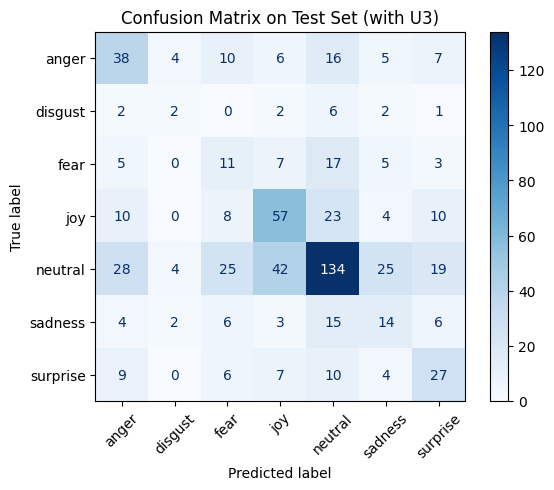

In [ ]:
# 22 Confusion Matrix on Test Set (with U3)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix for the model with U3
cm_with_u3 = confusion_matrix(test_true_with_u3, test_preds_with_u3)
disp_with_u3 = ConfusionMatrixDisplay(confusion_matrix=cm_with_u3, display_labels=label_encoder.classes_)
disp_with_u3.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix on Test Set (with U3)")
plt.grid(False)
plt.show()


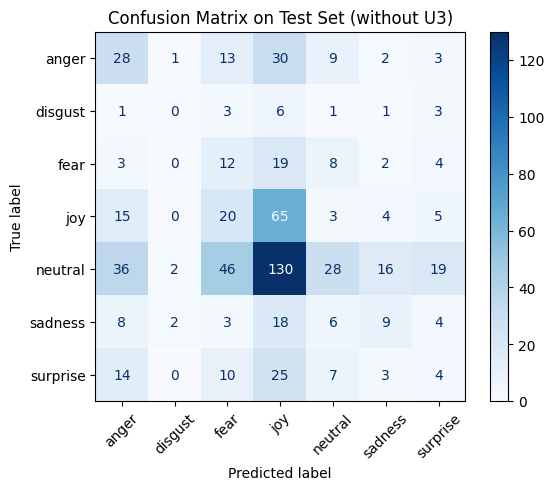

In [ ]:
# 23 Confusion Matrix on Test Set (without U3)


# Generate confusion matrix for the model without U3
cm_without_u3 = confusion_matrix(test_true_without_u3, test_preds_without_u3)
disp_without_u3 = ConfusionMatrixDisplay(confusion_matrix=cm_without_u3, display_labels=label_encoder.classes_)
disp_without_u3.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix on Test Set (without U3)")
plt.grid(False)
plt.show()
